<a href="https://colab.research.google.com/github/jazielcarballo/ML-2025/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

3. Illustrate the theorem with a numerical example in Python using synthetic data. Generate a
known endmember matrix E and an observed spectrum y (e.g., by mixing known abundances
and adding small noise). Compute aˆ and verify the identity numerically for a few different
choices of b ̸= aˆ.

In [1]:
import numpy as np

# Paso 1: Generar datos sintéticos
np.random.seed(0)
L, P = 5, 3  # número de bandas espectrales y endmembers

# Matriz de endmembers E (L x P)
E = np.random.rand(L, P)

# Vector de abundancias verdadero
a_true = np.array([0.5, 0.3, 0.2])

# Espectro observado con ruido
noise = np.random.normal(0, 0.01, L)
y = E @ a_true + noise

# Paso 2: Estimador OLS
a_hat = np.linalg.inv(E.T @ E) @ E.T @ y

# Paso 3: Crear vectores b ≠ a_hat
b1 = a_hat + np.random.normal(0, 0.05, P)
b2 = a_hat + np.array([0.1, -0.1, 0.05])
b3 = a_hat - np.random.normal(0, 0.07, P)

# Paso 4: Verificar la identidad para cada b
def verificar_identidad(b, E, y, a_hat):
    left = np.linalg.norm(y - E @ b) ** 2
    right = np.linalg.norm(y - E @ a_hat) ** 2 + np.linalg.norm(E @ (a_hat - b)) ** 2
    igual = np.isclose(left, right)
    return left, right, igual

# Resultados
print("Verificación de la identidad ||y - Eb||² = ||y - Eâ||² + ||E(â - b)||²\n")
for i, b in enumerate([b1, b2, b3], start=1):
    left, right, igual = verificar_identidad(b, E, y, a_hat)
    print(f"b{i}:")
    print(f"  ||y - Eb{i}||²               = {left:.6f}")
    print(f"  ||y - Eâ||² + ||E(â - b{i})||² = {right:.6f}")
    print(f"  ¿Se cumple la identidad?     {'✅' if igual else '❌'}\n")


Verificación de la identidad ||y - Eb||² = ||y - Eâ||² + ||E(â - b)||²

b1:
  ||y - Eb1||²               = 0.002551
  ||y - Eâ||² + ||E(â - b1)||² = 0.002551
  ¿Se cumple la identidad?     ✅

b2:
  ||y - Eb2||²               = 0.003605
  ||y - Eâ||² + ||E(â - b2)||² = 0.003605
  ¿Se cumple la identidad?     ✅

b3:
  ||y - Eb3||²               = 0.009187
  ||y - Eâ||² + ||E(â - b3)||² = 0.009187
  ¿Se cumple la identidad?     ✅



In [2]:
import numpy as np

# 1. Generar datos sintéticos
np.random.seed(42)
L, P = 5, 3
E = np.random.rand(L, P)                  # matriz de endmembers
a_true = np.array([0.5, 0.3, 0.2])        # abundancias verdaderas
noise = np.random.normal(0, 0.01, L)      # ruido pequeño
y = E @ a_true + noise                    # espectro observado con ruido

# 2. Calcular la estimación por mínimos cuadrados ordinarios
a_hat = np.linalg.inv(E.T @ E) @ E.T @ y

# 3. Probar la identidad para distintos vectores b ≠ a_hat
b_list = {
    "b1": a_hat + np.random.normal(0, 0.05, P),
    "b2": a_hat + np.random.normal(0, 0.1, P),
    "b3": a_hat + np.array([0.2, -0.1, 0.1])
}

# 4. Verificar la identidad para cada b
print("Verificación de la identidad ||y - Eb||² = ||y - Eâ||² + ||E(â - b)||²\n")
for name, b in b_list.items():
    left = np.linalg.norm(y - E @ b)**2
    right = np.linalg.norm(y - E @ a_hat)**2 + np.linalg.norm(E @ (a_hat - b))**2
    print(f"{name}:")
    print(f"  ||y - Eb||²              = {left:.6f}")
    print(f"  ||y - Eâ||² + ||E(â - b)||² = {right:.6f}")
    print(f"  ¿Son iguales? {'✅' if np.isclose(left, right) else '❌'}\n")


Verificación de la identidad ||y - Eb||² = ||y - Eâ||² + ||E(â - b)||²

b1:
  ||y - Eb||²              = 0.024926
  ||y - Eâ||² + ||E(â - b)||² = 0.024926
  ¿Son iguales? ✅

b2:
  ||y - Eb||²              = 0.161955
  ||y - Eâ||² + ||E(â - b)||² = 0.161955
  ¿Son iguales? ✅

b3:
  ||y - Eb||²              = 0.100375
  ||y - Eâ||² + ||E(â - b)||² = 0.100375
  ¿Son iguales? ✅



# Implementation of Regularized Unmixing
• Develop a Python function that performs spectral unmixing on a single pixel spectrum
y, given an endmember matrix E.

• The function should allow for the inclusion of L1, L2, or Elastic Net regularization terms.

• The function should allow for the enforcement of the Abundance Non-negativity Constraint
(ANC) and, optionally, the Abundance Sum-to-one Constraint (ASC).

• You should use scipy.optimize.minimize to solve the optimization problem defined
in Equation 5 subject to the selected constraints. The SLSQP solver is recommended for
its ability to handle bounds and equality/inequality constraints.

In [3]:
!pip install datasets

## Using Samsom dataset

In [4]:
# Paso 2: Importar librerías necesarias
import numpy as np
from scipy.io import loadmat
from scipy.optimize import minimize
import matplotlib.pyplot as plt


In [5]:
# Paso 3: Definir la función de unmixing regularizado
def regularized_unmixing(y, E, lambda1=0.0, lambda2=0.0, enforce_ANC=True, enforce_ASC=False):
    P = E.shape[1]

    def objective(a):
        residual = np.linalg.norm(E @ a - y)**2 / 2
        reg_l1 = lambda1 * np.sum(np.abs(a))
        reg_l2 = lambda2 * np.sum(a**2)
        return residual + reg_l1 + reg_l2

    a0 = np.ones(P) / P  # inicialización uniforme

    constraints = []
    if enforce_ASC:
        constraints.append({'type': 'eq', 'fun': lambda a: np.sum(a) - 1})

    bounds = [(0, None)] * P if enforce_ANC else [(None, None)] * P

    result = minimize(objective, a0, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x if result.success else None


In [6]:
# Paso 4: Cargar el archivo .mat y procesar los datos
samson_data = loadmat('/content/drive/MyDrive/3er cuatrimestre/ML/colabs/Data_Matlab/samson/samson.mat')

V = samson_data['V']
nRow = samson_data['nRow'][0][0]
nCol = samson_data['nCol'][0][0]
nBand = samson_data['nBand'][0][0]

# Reorganizar V en forma de cubo: (nRow, nCol, nBand)
cube = V.reshape((nBand, nCol, nRow)).transpose(2, 1, 0)  # (nRow, nCol, nBand)


In [7]:
# Paso 5: Cargar directamente los endmembers
endmembers_data = loadmat('/content/drive/MyDrive/3er cuatrimestre/ML/colabs/Data_Matlab/samson/end3.mat')

# Imprimir las claves disponibles en el diccionario para identificar el nombre correcto de la matriz de endmembers
print("Claves disponibles en end3.mat:")
print(endmembers_data.keys())



Claves disponibles en end3.mat:
dict_keys(['__header__', '__version__', '__globals__', 'cood', 'A', 'M'])


In [8]:
E = endmembers_data['M']
print("Forma de la matriz M:", E.shape)
print("Primeras filas de M:\n", E[:5])

Forma de la matriz M: (156, 3)
Primeras filas de M:
 [[0.10132159 0.01052632 0.16961617]
 [0.11894273 0.01538462 0.21796224]
 [0.12628488 0.01700405 0.24539143]
 [0.13362702 0.01862348 0.25851488]
 [0.13509545 0.0194332  0.25399547]]


In [9]:
# Paso 6: Seleccionar un píxel y aplicar unmixing
y_pixel = cube[50, 50, :]  # espectro del píxel (L,)

# Estimar abundancias
a_est = regularized_unmixing(
    y=y_pixel,
    E=E,
    lambda1=0.03,  # L1
    lambda2=0.02,  # L2
    enforce_ANC=True,
    enforce_ASC=True
)

print("Abundancias estimadas:", a_est)
print("Suma total:", np.sum(a_est))


Abundancias estimadas: [1.66580624e-15 8.36617442e-01 1.63382558e-01]
Suma total: 1.0


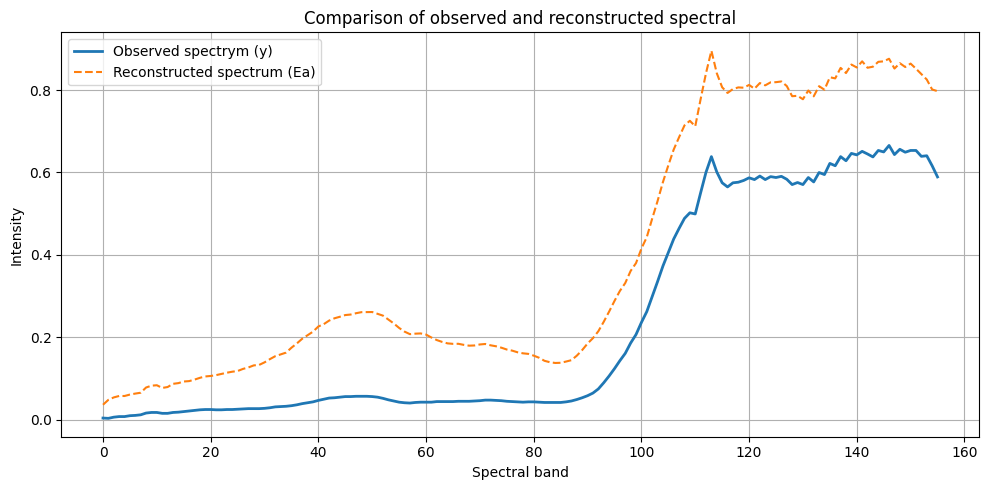

In [10]:
# Calcular el espectro reconstruido
y_reconstructed = E @ a_est

# Graficar el espectro original y el reconstruido
plt.figure(figsize=(10, 5))
plt.plot(y_pixel, label='Observed spectrym (y)', linewidth=2)
plt.plot(y_reconstructed, label='Reconstructed spectrum (Ea)', linestyle='--')
plt.title('Comparison of observed and reconstructed spectral')
plt.xlabel('Spectral band')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('comparison.png', dpi=300)
plt.show()


In [18]:
# Paso 1: Cargar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.io import loadmat
import os

# Paso 2: Funciones para unmixing regularizado
def regularized_unmixing(y, E, lambda1=0.0, lambda2=0.0, use_anc=True, use_asc=False):
    L, P = E.shape
    a0 = np.ones(P) / P

    def objective(a):
        residual = E @ a - y
        l2_term = lambda2 * np.sum(a ** 2)
        l1_term = lambda1 * np.sum(np.abs(a))
        return 0.5 * np.sum(residual ** 2) + l1_term + l2_term

    bounds = [(0, None) if use_anc else (None, None) for _ in range(P)]

    constraints = []
    if use_asc:
        constraints.append({'type': 'eq', 'fun': lambda a: np.sum(a) - 1})

    result = minimize(objective, a0, method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        return result.x
    else:
        return np.zeros(P)  # fallback si falla

# Paso 3: Cargar datos Samson y reshape
def load_samson_cube_and_endmembers(cube_path, endmembers_path):
    cube_data = loadmat(cube_path)
    endmember_data = loadmat(endmembers_path)
    V = cube_data['V']
    E = endmember_data['M']
    cube = V.reshape((156, 95, 95))
    return cube, E

# Paso 4: Aplicar unmixing a la imagen completa
def apply_unmixing_to_image(cube, E, lambda1=0.0, lambda2=0.0, use_asc=False):
    L, H, W = cube.shape
    P = E.shape[1]
    abundances_map = np.zeros((H, W, P))
    for i in range(H):
        for j in range(W):
            y = cube[:, i, j]
            a_hat = regularized_unmixing(y, E, lambda1=lambda1, lambda2=lambda2, use_anc=True, use_asc=use_asc)
            abundances_map[i, j, :] = a_hat
    return abundances_map

# Paso 5: Visualizar mapas de abundancia y guardar imágenes
def plot_abundance_maps(abundances, title_prefix=""):
    H, W, P = abundances.shape
    os.makedirs("output_maps", exist_ok=True)
    for p in range(P):
        plt.figure(figsize=(5, 4))
        plt.imshow(abundances[:, :, p], cmap='viridis')
        plt.colorbar(label="Abundance")
        plt.title(f"{title_prefix} Endmember {p+1}")
        plt.axis('off')
        filename = f"output_maps/{title_prefix.replace(' ', '_')}_Endmember_{p+1}.png"
        plt.savefig(filename, bbox_inches='tight')
        plt.show()
        plt.close()

# Paso 6: Ejecutar todos los experimentos
def run_all_experiments():
    cube_path = "/content/drive/MyDrive/3er cuatrimestre/ML/colabs/Data_Matlab/samson/samson.mat"  # Ruta directa al archivo
    endmembers_path = "/content/drive/MyDrive/3er cuatrimestre/ML/colabs/Data_Matlab/samson/end3.mat"  # Ruta directa al archivo

    cube, E = load_samson_cube_and_endmembers(cube_path, endmembers_path)

    configs = [
        ("No Regularization (ANC + ASC)", 0.0, 0.0, True),
        ("L2 Regularization (lambda2=0.1)", 0.0, 0.1, True),
        ("L1 Regularization (lambda1=0.1)", 0.1, 0.0, True),
        ("Elastic Net (lambda1=0.05, lambda2=0.05)", 0.05, 0.05, True),
        ("No ASC (Elastic Net)", 0.05, 0.05, False)
    ]

    for title, l1, l2, asc in configs:
        print(f"\nEjecutando experimento: {title}")
        abundances = apply_unmixing_to_image(cube, E, lambda1=l1, lambda2=l2, use_asc=asc)
        plot_abundance_maps(abundances, title_prefix=title)

# Para ejecutar:
# run_all_experiments()




Ejecutando experimento: No Regularization (ANC + ASC)


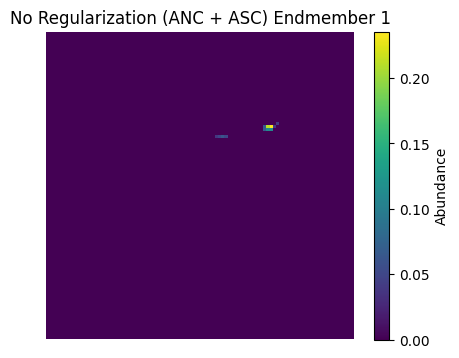

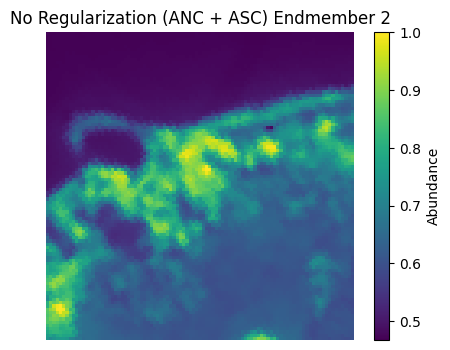

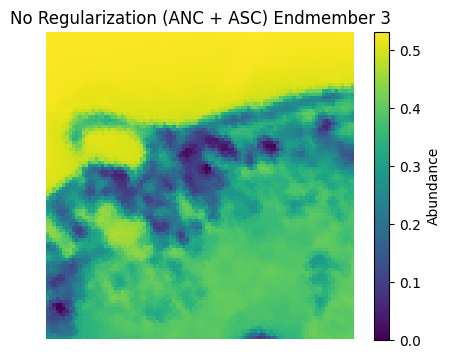


Ejecutando experimento: L2 Regularization (lambda2=0.1)


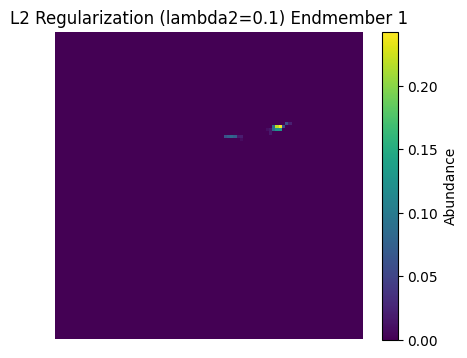

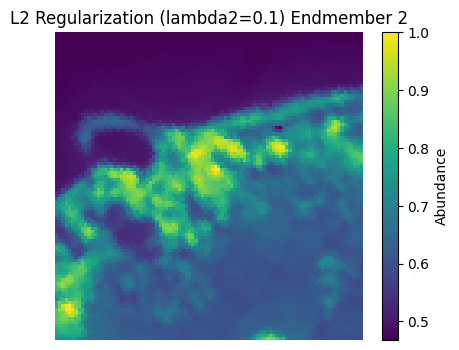

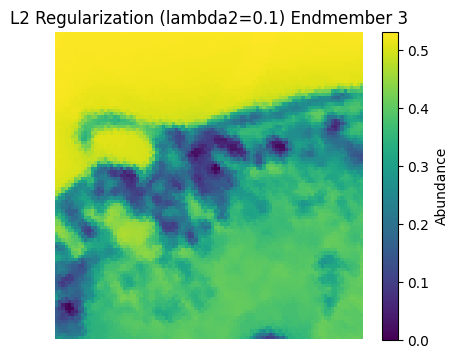


Ejecutando experimento: L1 Regularization (lambda1=0.1)


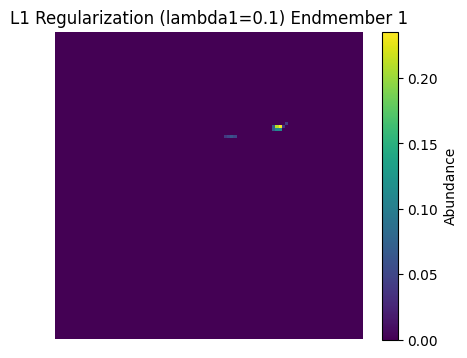

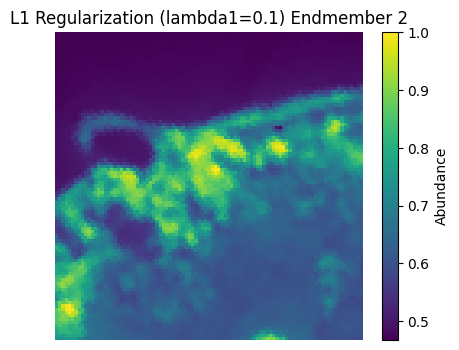

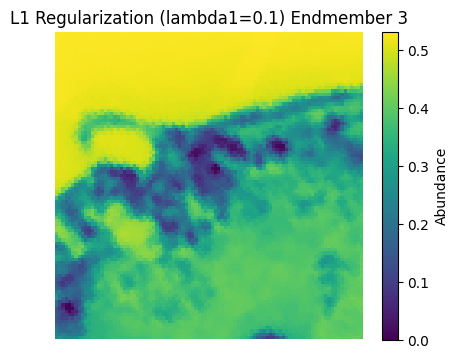


Ejecutando experimento: Elastic Net (lambda1=0.05, lambda2=0.05)


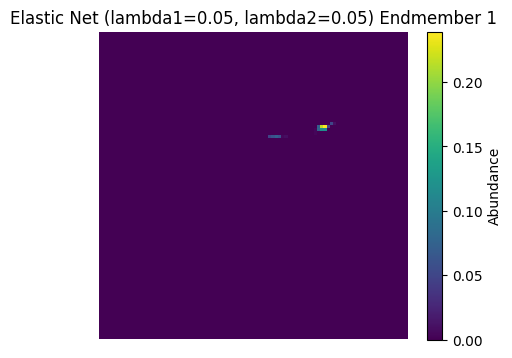

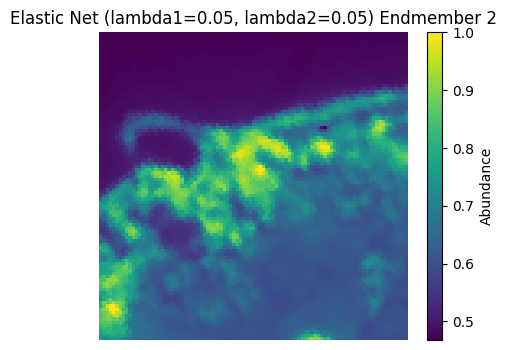

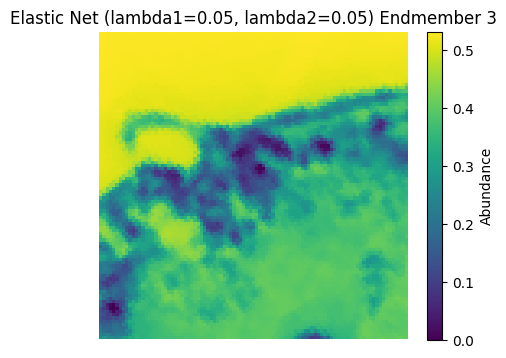


Ejecutando experimento: No ASC (Elastic Net)


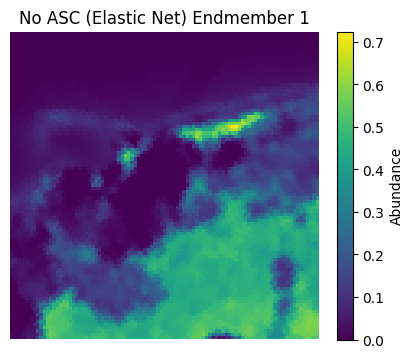

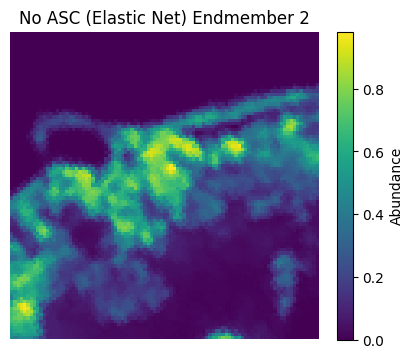

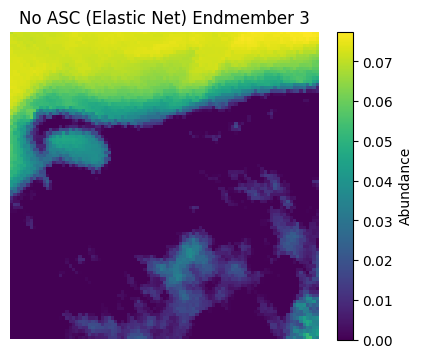

In [19]:
run_all_experiments()